In [22]:
!find tiles_768 -type f | wc -l

709484


In [ ]:
!find tiles_768 -type d | wc -l

In [24]:
!free -h

               total        used        free      shared  buff/cache   available
Mem:            50Gi       1.2Gi        29Gi       0.0Ki        20Gi        49Gi
Swap:             0B          0B          0B


In [27]:
!nvidia-smi

Mon Nov 20 18:52:44 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            On   | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    45W /  75W |   5368MiB /  7680MiB |     34%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

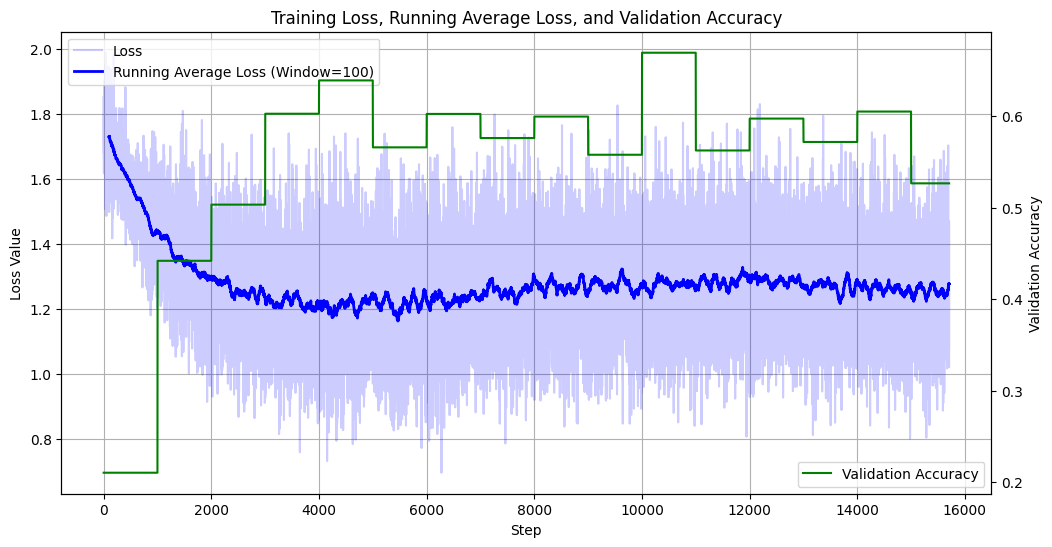

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Read and parse the training log file
file_path = 'logs/training_log_finetune_vit_non_tma_pt_4.txt'  # Replace with the path to your file

steps = []
losses = []
val_accuracies = []
val_accuracy_steps = []
last_step = None

loss_pattern = re.compile(r'\[\d+, +(\d+)\] loss: ([\d.]+)')
val_acc_pattern = re.compile(r'Validation Accuracy: ([\d.]+)')

with open(file_path, 'r') as file:
    for line in file:
        # Extracting loss and step
        loss_match = loss_pattern.match(line)
        if loss_match:
            step, loss = map(float, loss_match.groups())
            steps.append(step)
            losses.append(loss)
            last_step = step
        # Extracting validation accuracy
        val_acc_match = val_acc_pattern.match(line)
        if val_acc_match and last_step is not None:
            val_accuracy = float(val_acc_match.group(1))
            val_accuracies.append(val_accuracy)
            val_accuracy_steps.append(last_step)

# Create a DataFrame to store the validation accuracy with the updated steps
val_accuracy_data = pd.DataFrame({
    'Step': val_accuracy_steps,
    'Validation Accuracy': val_accuracies
})

# Create a DataFrame to store the loss and running average loss
data = pd.DataFrame({
    'Step': steps,
    'Loss': losses
})
window = 100
data['Running Average Loss'] = data['Loss'].rolling(window=window).mean()

# Merge the data to align validation accuracy with the correct steps
merged_data = pd.merge(data, val_accuracy_data, on='Step', how='left')
merged_data['Validation Accuracy'] = merged_data['Validation Accuracy'].ffill()

# Plot the graph
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotting Loss and Running Average Loss on the primary y-axis
ax1.plot(merged_data['Step'], merged_data['Loss'], label='Loss', alpha=0.2, color='blue')
ax1.plot(merged_data['Step'], merged_data['Running Average Loss'], label=f'Running Average Loss (Window={window})', linewidth=2, color='blue')

# Setting labels and title for the primary y-axis
ax1.set_xlabel('Step')
ax1.set_ylabel('Loss Value')
ax1.legend(loc='upper left')
ax1.grid(True)

ax1.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Creating a secondary y-axis for Validation Accuracy
ax2 = ax1.twinx()
ax2.plot(merged_data['Step'], merged_data['Validation Accuracy'], label='Validation Accuracy', color='green')
ax2.set_ylabel('Validation Accuracy')
ax2.legend(loc='lower right')

# Adding a title to the plot
plt.title('Training Loss, Running Average Loss, and Validation Accuracy')

plt.show()
